# Import libraries

In [2]:
import os
from os import path, getcwd, chdir
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

print(tf.__version__)

2.7.0


In [3]:
def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("time")
  plt.ylabel("value")
  plt.grid(True)

# Data
## Open and reshape raw datasets

In [4]:
file_path = '/content/drive/MyDrive/motion_dataset/'
train_path = file_path + 'train_dataset/'

In [5]:
dataset = np.loadtxt(train_path+'dataset_withlabels.txt')
print(dataset.shape)

(3718058, 7)


In [6]:
dataset.shape[0]

3718058

In [7]:
# drop some values from dataset to reshape them properly by using indexing
org_size = dataset.shape[0]
new_size = 200
reshape_dataset = dataset[(org_size%new_size):, :].reshape((-1,200,7)) #뒤에서 데이터를 자르면 앉기 데이터가 상당 부분 소실되어서, 앞에서 crop함. 
print(reshape_dataset.shape)

(18590, 200, 7)


## Spliting Train set & Test Set 



In [8]:
# using sklearn.model_selection
trainx, testx, trainy, testy = train_test_split(reshape_dataset[:,:,0:6], # x 0~5
                                                reshape_dataset[:,:,6], # y 6
                                                test_size=0.3,
                                                shuffle = True,
                                                random_state = 1004)

print('trainx shape:', trainx.shape)
print('testx shape:', testx.shape)
print('trainy shape:', trainy.shape)
print('testy shape:', testy.shape)

trainx shape: (13013, 200, 6)
testx shape: (5577, 200, 6)
trainy shape: (13013, 200)
testy shape: (5577, 200)


In [9]:
# reshape trainy and testy from (n, 200) to (n, 1) = indexing and .reshape((n,1)).astype(int)
# to remain the only label per one motion (200*5)
trainy = trainy[:, 0].reshape((trainy.shape[0],1)).astype(int)
testy = testy[:, 0].reshape((testy.shape[0],1)).astype(int)
print('trainy shape:', trainy.shape)
print('testy shape:', testy.shape)
print(trainy)
print(testy)

# change the label value 1,2,3,4 -> 0,1,2,3

trainy = trainy -1
testy = testy - 1
# check again the unique values in testy and trainy set
print(np.unique(trainy))
print(np.unique(testy))

trainy shape: (13013, 1)
testy shape: (5577, 1)
[[1]
 [1]
 [3]
 ...
 [3]
 [1]
 [3]]
[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [1]]
[0 1 2 3]
[0 1 2 3]


In [ ]:
# trainy = to_categorical(trainy, 4)
# testy = to_categorical(testy, 4)

# Model

In [15]:
def train_motion(trainx, trainy, testx, testy):

  class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('acc') > 0.990:
        print("\nReached 99.0% accuracy so canceling training.")

  callbacks = myCallback()

  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(units = 200, input_shape = (200,6), return_sequences = False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(4, activation = 'softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics =['acc'])
  history = model.fit(trainx, trainy,
                      validation_data = (testx, testy),
                      epochs = 10,
                      callbacks=[callbacks])
  
  acc = history.history['acc']
  loss = history.history['loss']
  val_acc = history.history['val_acc']
  val_loss = history.history['val_loss']
  # history.epoch, history.history['acc'][-1]
  return model.summary, acc, loss, val_acc, val_loss

In [16]:
#model1 = train_motion(trainx, trainy, testx, testy)
model2 = train_motion(trainx, trainy, testx, testy)


Epoch 1/10
407/407 [==============================] - 202s 491ms/step - loss: 0.3601 - acc: 0.9177 - val_loss: 0.1435 - val_acc: 0.9631
Epoch 2/10
407/407 [==============================] - 198s 487ms/step - loss: 0.1661 - acc: 0.9520 - val_loss: 0.1214 - val_acc: 0.9686
Epoch 3/10
407/407 [==============================] - 202s 498ms/step - loss: 0.1283 - acc: 0.9614 - val_loss: 0.1203 - val_acc: 0.9666
Epoch 4/10
407/407 [==============================] - 201s 494ms/step - loss: 0.1194 - acc: 0.9647 - val_loss: 0.1062 - val_acc: 0.9686
Epoch 5/10
407/407 [==============================] - 196s 481ms/step - loss: 0.1109 - acc: 0.9674 - val_loss: 0.1013 - val_acc: 0.9686
Epoch 6/10
407/407 [==============================] - 194s 477ms/step - loss: 0.1032 - acc: 0.9684 - val_loss: 0.0925 - val_acc: 0.9738
Epoch 7/10
407/407 [==============================] - 198s 486ms/step - loss: 0.0818 - acc: 0.9740 - val_loss: 0.0883 - val_acc: 0.9740
Epoch 8/10
407/407 [============================

In [17]:
model2[0]()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               165600    
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 804       
                                                                 
Total params: 167,204
Trainable params: 166,804
Non-trainable params: 400
_________________________________________________________________


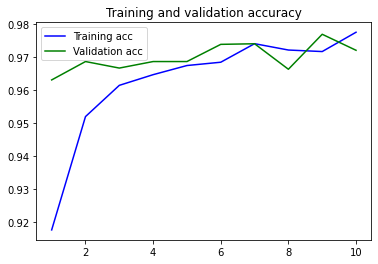

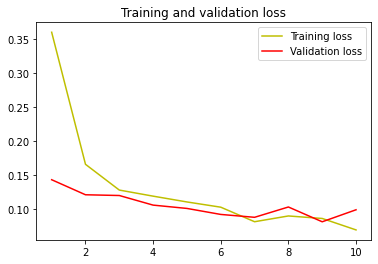

In [18]:
acc = model2[1]
loss = model2[2]
val_acc = model2[3]
val_loss = model2[4]

# 학습과정 시각화
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
tf.keras.backend.clear_session()